# Training data numdet_png

In [2]:
#Train
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import pandas as pd
import os
import csv
import numpy as np

import time
import threading

from fastai.vision import *
from fastai.metrics import error_rate
import re

#debug
from debug import *

In [8]:
path = Path("data/numdet/numdet_png")
tfms = get_transforms(do_flip=False)
path_files_num_all = list(path.glob('**/*.jpg'))

In [67]:

#"mix_0_0.jpg","!mix_no_2.jpg"
pat = "([\w!]+)_[no0-9]+_\d+\.jpg$"
data = ImageDataBunch.from_name_re(path, path_files_num_all, pat=pat, ds_tfms=tfms) #, size=24



In [6]:
pat = "([\w!]+)_[no0-9]+_\d+\.jpg$"
n = re.search(pat,"!mix_no_200.jpg")
n.group(1)

'!mix'

In [70]:
data.classes

['!mix', 'mix']

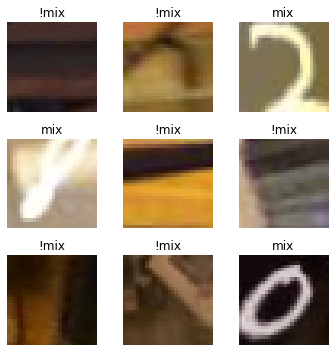

In [71]:
data.show_batch(rows=3, figsize=(5,5))

In [72]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [03:48<00:00, 205kB/s] 


In [73]:
learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.121609,0.070518,0.973786,24:32
1,0.064756,0.041609,0.986000,14:11


In [75]:
learn.export('numdet_resnet18_full_1.pkl')

In [177]:
data.train_ds[20100][0]

In [8]:
image = cv2.imread("data/testimg_num_none_1.jpg")
image = cv2.resize(image,(28,28), interpolation = cv2.INTER_AREA) 

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
#edged = cv2.Canny(blurred, 50, 200, 255)
edged = cv2.cvtColor(blurred,cv2.COLOR_GRAY2RGB)

#blurred.shape
edged = np.clip(edged, 0, 255)
test_img = Image(np.clip(pil2tensor(edged,np.float32).div_(-255).add_(1).mul_(3), 0, 1)     )


def get_result(model,image):
    list_result = list(model.predict(image)[2])
    max_value = max(list_result)
    max_index = list_result.index(max_value)
    return max_index,max_value


test_result = get_result(learn,test_img)



NameError: name 'learn' is not defined